## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, symbol_to_id
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict

from torch.nn import functional as F

from sklearn.metrics.pairwise import cosine_similarity as cs


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

from audio_processing import get_mel

loaded = False



In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.end_symbols_ids = [symbol_to_id[s] for s in '?!.']
# hparams.use_gst = False

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
checkpoint_path = "checkpoint_77000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [5]:
ref_mel = get_mel('test/test5.wav', hparams).type(torch.HalfTensor).cuda()
print(ref_mel.dtype, ref_mel.shape)

torch.float16 torch.Size([1, 80, 1039])


In [193]:

text = "Тетрагидропиранилциклопентилтетрагидропиридопиридиновые вещества".lower()
text = "Мин+истр здравоохран+ения улет+ел. И обещ+ал верн+уться. С вакц+инами. Нав+ерно, +есть как+ой-то м+ир, где мин+истрам л+ично н+адо лет+ать за вакц+инами с четырьм+я перес+адками во вр+емя эпид+емии. М+ожет по+этому в Зимб+абве уже вакцин+ируют, потом+у чт+о их мин+истр л+ично с+ел на слон+а и по+ехал на нем в больш+ой г+ород преклон+ить кол+ено и получ+ить вакц+ину? Так+ой м+ир нам пыт+аются прод+ать?".lower()
text = "Вс+е смеш+алось в д+оме Обл+онских. Жен+а узн+ала, что муж был в св+язи с б+ывшею в их д+оме франц+уженкою-гуверн+анткой, и объяв+ила м+ужу, что не м+ожет ж+ить с ним в одн+ом д+оме. Полож+ение это продолж+алось уже третий д+ень и муч+ительно ч+увствовалось и сам+ими супр+угами, и вс+еми чл+енами семь+и, и домоч+адцами."
# text = "Тв+орог или твор+ог, к+озлы или козл+ы, з+амок или зам+ок.".lower()
# text="мн+е хот+елось б+ы? сказ+ать к+ак я призн+ателен вс+ем прис+утсвующим сд+есь."
# text = "tak+oi m+ir n+am pyt+aiutsia prod+at'?"
# text = "сказ+ал? сказ+ал!"
# text = "В+ыйду,,,,,,, н+очью,,, в п+оле,,, с кон+ем"
# text = "Н+очь, +улица, фон+арь, апт+ека. Бессм+ысленный, и т+усклый св+ет. Жив+и ещ+е х+оть ч+етверть в+ека - Вс+ё б+удет т+ак. Исх+ода н+ет."
# text = "Ночь, улица, фонарь, аптека. Бессмысленный, и тусклый свет. Жив+и еще хоть четверть века - Все будет так. Исхода нет."
text = "Игра - тип осмысленной непродуктивной деятельности, где мотив лежит не в её результате, а в самом процессе. Также термин игра используют для обозначения набора предметов или программ, предназначенных для подобной деятельности."
text = "Прижм+ись к+о мн+е кр+епче и бл+иже. Не ж+ил я, блужд+ал ср+едь чуж+их. О, с+он м+ой, Я н+овое в+ижу, В бред+у поцел+уев тво+их!"

print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners_with_stress']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Sprizhm+is' k+o mn+e kr+epche i bl+izhe. ne zh+il +ia, bluzhd+al sr+ed' chuzh+ikh. o, s+on m+oi, +ia n+ovoe v+izhu, v bred+u potsel+uev tvo+ikh!E
[[12 29 31 22 39 21 26 40 22 32  3 11 24 40 28 11 26 27 40 18 11 24 31 40
  18 29 16 21 18 11 22 11 15 25 40 22 39 21 18  7 11 27 18 11 39 21 40 22
  25 11 40 22 14  6 11 15 25 34 39 21 17 40 14 25 11 32 31 40 18 17  3 11
  16 21 34 39 21 40 22 24 21  7 11 28  6 11 32 40 28 27 11 26 40 28 22  6
  11 40 22 14 11 27 40 28 35 28 18 11 35 40 22 39 21 34  6 11 35 11 15 31
  18 17 40 34 11 29 28 33 32 18 25 40 34 18 35 11 33 35 28 40 22 24 21  2
  13]]


In [216]:
%%time
# np.random.seed(16)

_, mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence,seed=123456, reference_mel=ref_mel, scale=100000.0)

tensor(0.1160, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)
CPU times: user 4.38 s, sys: 0 ns, total: 4.38 s
Wall time: 4.38 s


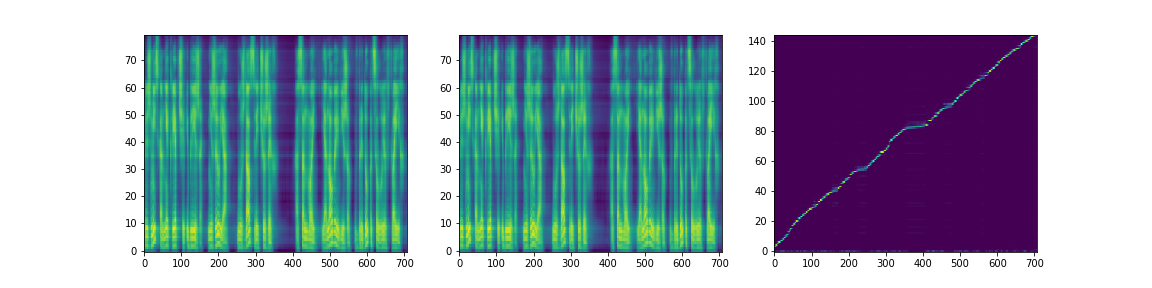

In [217]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [218]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

if not loaded:
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    loaded=True

def inference(mel, generator):
    

    
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    


In [219]:
%%time
mel = mel_outputs_postnet.type(torch.float32)

audio = inference(mel, generator)
ipd.Audio(audio, rate=hparams.sampling_rate)              

CPU times: user 2.3 s, sys: 3.82 ms, total: 2.3 s
Wall time: 2.3 s


In [17]:
# style vectors similarity
vect = model.gst.stl.embed

In [18]:
norm = F.normalize(vect, dim=1).detach().cpu().numpy()
res =  cs(norm, norm)
res

array([[ 1.        , -0.45077495, -0.26381129,  0.11154567,  0.03254981,
         0.01212555, -0.18702013, -0.21805649,  0.11469363,  0.01724787],
       [-0.45077495,  1.        ,  0.06108587,  0.15726627,  0.00897179,
        -0.2710837 , -0.19771002, -0.01540994, -0.49491478,  0.10342892],
       [-0.26381129,  0.06108587,  1.        ,  0.01941217, -0.20064925,
        -0.12716174,  0.05604637, -0.14543353, -0.15928464, -0.33432837],
       [ 0.11154567,  0.15726627,  0.01941217,  1.        , -0.20141422,
        -0.02090756, -0.28894042, -0.53222497, -0.26642282, -0.02134679],
       [ 0.03254981,  0.00897179, -0.20064925, -0.20141422,  1.        ,
        -0.33243494, -0.19544216, -0.1196307 ,  0.05320405,  0.02267011],
       [ 0.01212555, -0.2710837 , -0.12716174, -0.02090756, -0.33243494,
         1.        , -0.09837379,  0.01775505,  0.05909103, -0.26362952],
       [-0.18702013, -0.19771002,  0.05604637, -0.28894042, -0.19544216,
        -0.09837379,  1.        ,  0.0704386 